In [1]:
import pandas as pd
import numpy as np

import datetime 
import time

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.utils import plot_model

# !pip install matplotlib-venn
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles


import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import shuffle


In [2]:
!unzip -n archive.zip

Archive:  archive.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


Considering the order of rating preference for an user being defined in the order of viewing-->addtocart and then transaction

Log scale signifies that 10 number of views is equivalent to 1 instance of addting to cart
Same analogy can be applied to cart:transaction

We can keep duplicates of users and items and describe preference order as 1,2 and 3 for viewing, adding and transaction but then tis orinality will make less sense.

Else we can play with these values


In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
events_df = pd.read_csv('./events.csv')

events_df.head()
events_df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [5]:
events_df = pd.read_csv('./events.csv')

events_df.head()
# events_df.shape


events_df.event.value_counts()
# events_df.nunique()
#buying as 3,add_to_cart=2,view=1



# events_df.dropna(inplace=True)
events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
# events_df.drop_duplicates(subset=
                          # ['visitorid','itemid']).shape[0]/events_df.shape[0]

df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()

In [6]:
df_events.describe().round()

# df_events.

,visitorid,itemid,rating
count,2145179.0,2145179.0,2145179.0
mean,702031.0,234614.0,0.0
std,405680.0,134116.0,1.0
min,0.0,3.0,0.0
25%,350566.0,117673.0,0.0
50%,702113.0,235401.0,0.0
75%,1052906.0,350399.0,0.0
max,1407579.0,466867.0,142.0


In [7]:
# df_events.rating.value_counts().astype(float).plot(kind='hist',bins=20)

events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)

In [8]:
df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,1,10,1000],right=False,
                      labels=[1,2,3],
                      include_lowest=True)
#Views,addt0cart,transaction

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)
df_events.cum_rating.value_counts()
df_events.loc[:,'cum_rating']=df_events.loc[:,'cum_rating'].astype(int)
#just_views,higher_views,addt0cart,transaction

In [9]:
df_events.cum_rating.value_counts()


1    1801793
2     277000
3      45071
4      21315
Name: cum_rating, dtype: int64

In [10]:
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(0.1*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


2    277000
1    180179
3     45071
4     21315
Name: cum_rating, dtype: int64

Need to have zero start and continuous,increment by 1
items and users ids do as to formulate embedder matrix

In [11]:
current_user_id = 0
custom_user_map = {} # old user id > new user id
def map_user_id(row):
  global current_user_id, custom_user_map
  old_user_id = row['visitorid']
  if old_user_id not in custom_user_map:
    custom_user_map[old_user_id] = current_user_id
    current_user_id += 1
  return custom_user_map[old_user_id]

df_events['new_vis_id'] = df_events.apply(map_user_id, axis=1)


current_item_id = 0
custom_item_map = {} # old user id > new user id
def map_user_id(row):
  global current_item_id, custom_item_map
  old_item_id = row['itemid']
  if old_item_id not in custom_item_map:
    custom_item_map[old_item_id] = current_item_id
    current_item_id += 1
  return custom_item_map[old_item_id]

df_events['new_item_id'] = df_events.apply(map_user_id, axis=1)

In [12]:
df_events.columns

# df_events.visitorid = pd.Categorical(df_events.visitorid)
# df_events['new_vis_id'] = df_events.visitorid.cat.codes

# df_events.itemid = pd.Categorical(df_events.itemid)
# df_events['new_item_id'] = df_events.itemid.cat.codes
assert(df_events['new_item_id'].nunique()==(df_events['new_item_id'].max()-df_events['new_item_id'].min() +1))
assert(df_events['new_vis_id'].nunique()==(df_events['new_vis_id'].max()-df_events['new_vis_id'].min() +1))#therefore we have contnious arrangement of unique values


In [13]:
df_events.head()

,visitorid,itemid,rating,cum_rating,new_vis_id,new_item_id
269327,175098,142290,0.1,1,0,0
1137864,744937,339808,0.1,1,1,1
1988212,1303093,382690,0.1,1,2,2
1994227,1307262,62372,0.1,1,3,3
724801,474841,459345,0.1,1,4,4


In [14]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values

In [15]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
N,M

(379202, 120304)

In [16]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
# split the data
#will create hold out set later, need to devise a way
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating

In [18]:
pow(0.6,1/2)

0.7745966692414834

In [19]:
r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/25
435/435 - 4s - loss: 0.5856 - val_loss: 0.5571 - 4s/epoch - 10ms/step
Epoch 2/25
435/435 - 2s - loss: 0.5634 - val_loss: 0.5573 - 2s/epoch - 5ms/step
Epoch 3/25
435/435 - 2s - loss: 0.5633 - val_loss: 0.5578 - 2s/epoch - 5ms/step
Epoch 4/25
435/435 - 2s - loss: 0.5630 - val_loss: 0.5569 - 2s/epoch - 5ms/step
Epoch 5/25
435/435 - 2s - loss: 0.5586 - val_loss: 0.5480 - 2s/epoch - 5ms/step
Epoch 6/25
435/435 - 2s - loss: 0.5432 - val_loss: 0.5391 - 2s/epoch - 5ms/step
Epoch 7/25
435/435 - 2s - loss: 0.5318 - val_loss: 0.5501 - 2s/epoch - 5ms/step
Epoch 8/25
435/435 - 2s - loss: 0.5168 - val_loss: 0.5683 - 2s/epoch - 5ms/step
Epoch 9/25
435/435 - 2s - loss: 0.4985 - val_loss: 0.5864 - 2s/epoch - 5ms/step
Epoch 10/25
435/435 - 2s - loss: 0.4772 - val_loss: 0.5636 - 2s/epoch - 5ms/step
Epoch 11/25
435/435 - 2s - loss: 0.4552 - val_loss: 0.6024 - 2s/epoch - 5ms/step
Epoch 12/25
435/435 - 2s - loss: 0.4334 - val_loss: 0.5226 - 2s/epoch - 5ms/step
Epoch 13/25
435/435 - 2s - loss: 0.4

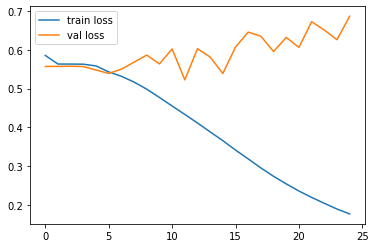

In [20]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

With larger training data

In [42]:
import re

In [21]:
model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=10,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/10
435/435 - 2s - loss: 0.1658 - val_loss: 0.6500 - 2s/epoch - 5ms/step
Epoch 2/10
435/435 - 2s - loss: 0.1543 - val_loss: 0.6361 - 2s/epoch - 5ms/step
Epoch 3/10
435/435 - 2s - loss: 0.1439 - val_loss: 0.6199 - 2s/epoch - 5ms/step
Epoch 4/10
435/435 - 2s - loss: 0.1357 - val_loss: 0.6539 - 2s/epoch - 5ms/step
Epoch 5/10
435/435 - 2s - loss: 0.1266 - val_loss: 0.6473 - 2s/epoch - 5ms/step
Epoch 6/10
435/435 - 2s - loss: 0.1181 - val_loss: 0.5845 - 2s/epoch - 5ms/step
Epoch 7/10
435/435 - 2s - loss: 0.1109 - val_loss: 0.6080 - 2s/epoch - 5ms/step
Epoch 8/10
435/435 - 2s - loss: 0.1033 - val_loss: 0.6574 - 2s/epoch - 5ms/step
Epoch 9/10
435/435 - 2s - loss: 0.0962 - val_loss: 0.6394 - 2s/epoch - 5ms/step
Epoch 10/10
435/435 - 2s - loss: 0.0898 - val_loss: 0.6404 - 2s/epoch - 5ms/step


In [94]:
user_7412=model.predict([np.array([7412]*len(item_ids)),item_ids])


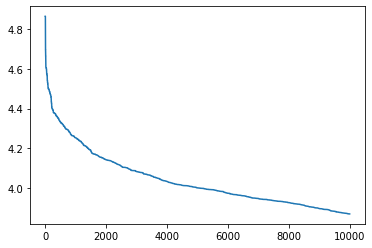

In [104]:
plt.plot(np.sort(user_7412.reshape(-1,))[::-1][:10000])


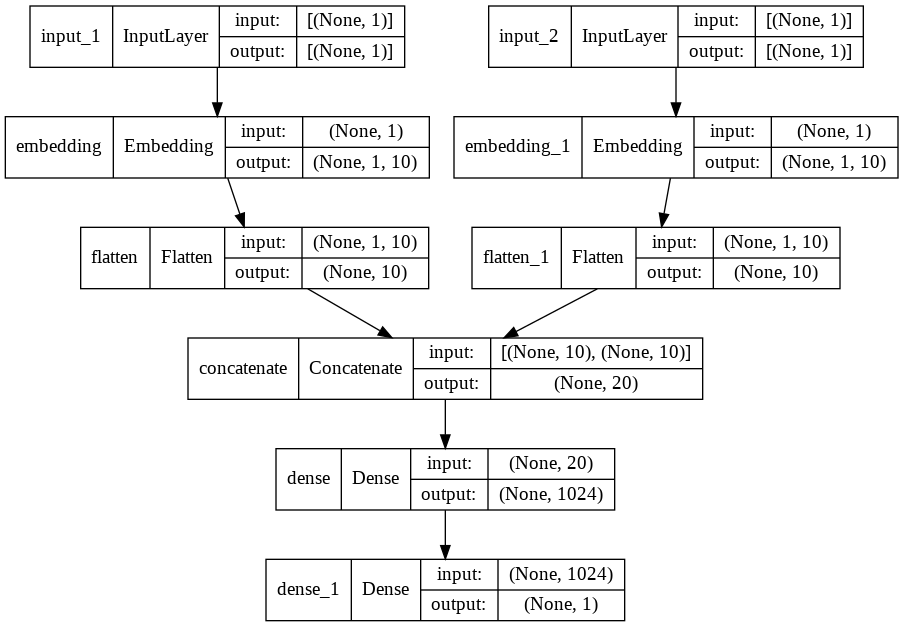

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

# Embedder Matrix based experiemntation

In [23]:
user_embd=model.layers[2].get_weights()[0]
item_embd=model.layers[3].get_weights()[0]

Int64Index([3719,   10, 2092, 2574,   75, 2532,  570, 2111, 1786, 2384,  465,
             226,  419, 3046, 2146,  471, 9203,  724, 2369, 9331,   50,  648,
              90, 1963, 9659, 5416, 2813, 8789, 1511, 3945],
           dtype='int64')

In [33]:
num_users=50
latent_factors=10

top_200_users_id=df_events.new_vis_id.value_counts().iloc[:num_users].index
top_200_users=user_embd[top_200_users_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_200_users
).reshape(-1,1)

top_200_users=np.concatenate([top_200_users,mag_factors],axis=1)

temp_1=top_200_users.reshape(num_users,1,latent_factors+1)
temp_2=top_200_users.reshape(1,num_users,latent_factors+1)


numerator=temp_1[...,:latent_factors]*temp_2[...,:latent_factors]
denominator=temp_1[...,latent_factors]*temp_2[...,latent_factors]


# (numerator/denominator)#.sum(axis=2)
df_cos=pd.DataFrame(numerator.sum(axis=2)/denominator
                    ,columns=['user_'+str(i) for i in top_200_users_id],
                    index=['user_'+str(i) for i in top_200_users_id])




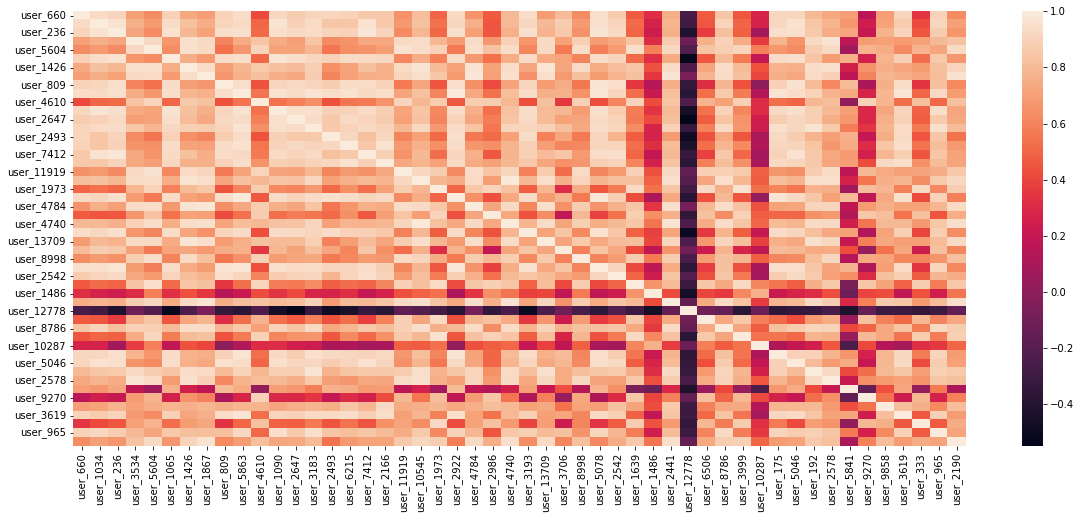

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
sns.heatmap(df_cos.iloc[:50,:50])#,annot=True)

# User-Item similarity

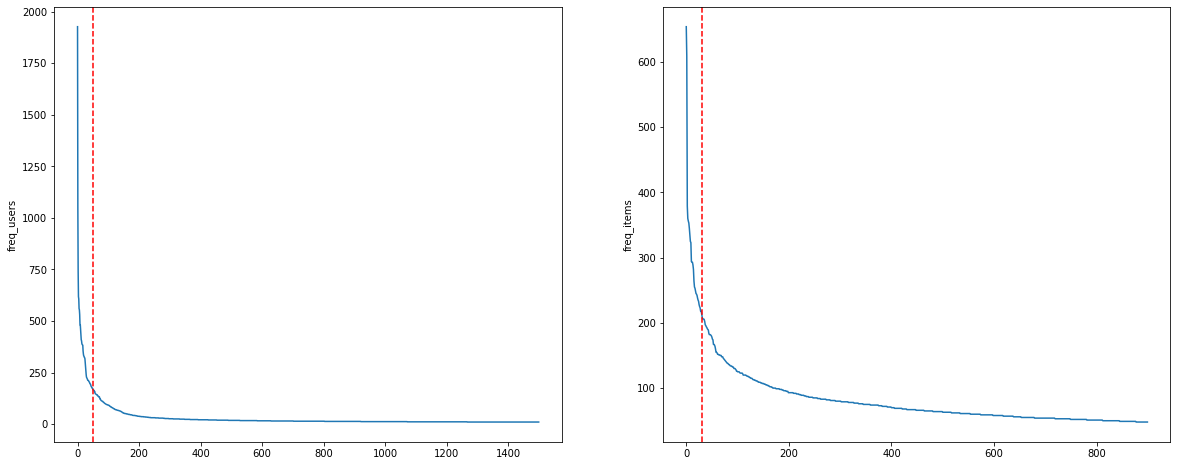

In [35]:
_,ax=plt.subplots(1,2,figsize=(20,8))
num_users=50
num_items=30
latent_factors=10

df_events.new_vis_id.value_counts().iloc[:30*num_users].reset_index(drop=True).plot(ax=ax[0])#kind='hist',bins=100,ax=ax[0])
ax[0].set_ylabel('freq_users')
ax[0].axvline(num_users,color='red',linestyle='--')

df_events.new_item_id.value_counts().iloc[:30*num_items].reset_index(drop=True).plot(ax=ax[1])#(kind='hist',bins=100,ax=ax[1])
ax[1].set_ylabel('freq_items')
ax[1].axvline(num_items,color='red',linestyle='--')


In [36]:
num_users=50
num_items=30
latent_factors=10

top_200_users_id=df_events.new_vis_id.value_counts().iloc[:num_users].index
top_200_users=user_embd[top_200_users_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_200_users
).reshape(-1,1)

top_200_users=np.concatenate([top_200_users,mag_factors],axis=1)

####################ITEMS####################################

top_items_id=df_events.new_item_id.value_counts().iloc[:num_items].index
top_items=user_embd[top_items_id,:]


mag_factors=np.apply_along_axis(
    lambda r: pow(np.sum(pow(r,2)),0.5),
    1,
    top_items
).reshape(-1,1)

top_items=np.concatenate([top_items,mag_factors],axis=1)


temp_1=top_200_users.reshape(num_users,1,latent_factors+1)
temp_2=top_items.reshape(1,num_items,latent_factors+1)


numerator=temp_1[...,:latent_factors]*temp_2[...,:latent_factors]
denominator=temp_1[...,latent_factors]*temp_2[...,latent_factors]


# (numerator/denominator)#.sum(axis=2)
df_cos_cross=pd.DataFrame(numerator.sum(axis=2)/denominator
                    ,columns=['item_'+str(i) for i in top_items_id],
                    index=['user_'+str(i) for i in top_200_users_id])




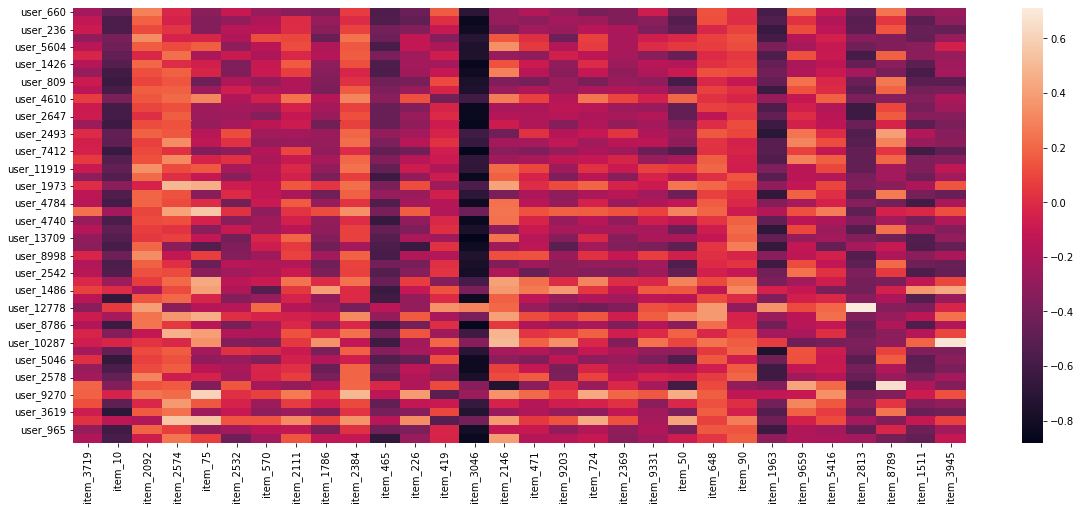

In [37]:
plt.figure(figsize=(20,8))
sns.heatmap(df_cos_cross)#,annot=True)

In [38]:
# set(df_events[df_events.new_vis_id==905]['new_item_id'])-set(df_events[df_events.new_vis_id==37]['new_item_id'])

In [39]:
temp=np.array([[100,500,300],
          [1,2,3]])


temp=np.concatenate([temp,temp.sum(axis=1).reshape(-1,1)],axis=1)

#cosine = element wise multiplication of latent factors/ magnitude of latent vectors computed about origin
#we can compute magntude as appended vector to top 200 users and then use it for division



o=temp.reshape(2,1,4)
t=temp.reshape(1,2,4)


numerator=o[...,:3]*t[...,:3]
denominator=o[...,3]*t[...,3]


# (numerator/denominator)#.sum(axis=2)
numerator.sum(axis=2)/denominator

array([[0.43209877, 0.37037037],
       [0.37037037, 0.38888889]])

In [80]:
user_tbu=7412
cor_users=df_cos.loc['user_'+str(user_tbu),:].sort_values(ascending=False)[1:4].index

pd.concat([df_cos_cross.sample(frac=0.2),df_cos_cross.loc[list(cor_users)+['user_'+str(user_tbu)],:]]).drop_duplicates().\
sample(frac=1).style.apply(lambda x: ['background: lightgreen' if x.name in cor_users 
                              else '' for i in x], axis=1)


,item_3719,item_10,item_2092,item_2574,item_75,item_2532,item_570,item_2111,item_1786,item_2384,item_465,item_226,item_419,item_3046,item_2146,item_471,item_9203,item_724,item_2369,item_9331,item_50,item_648,item_90,item_1963,item_9659,item_5416,item_2813,item_8789,item_1511,item_3945
user_236,-0.087249,-0.559627,0.103475,0.033034,-0.349727,-0.159605,-0.147668,0.007530,-0.328325,0.089073,-0.414000,-0.358016,-0.097291,-0.810181,-0.362109,-0.245196,-0.276573,-0.156460,-0.196891,-0.375739,-0.485300,-0.016584,0.084238,-0.642819,0.117741,-0.143970,-0.501334,0.140801,-0.455225,-0.469661
user_192,-0.282136,-0.557594,0.111746,0.164769,-0.150688,-0.209385,-0.022643,0.015926,-0.448159,0.189495,-0.395755,-0.145991,-0.254916,-0.828496,0.072559,-0.104870,-0.377326,-0.028768,-0.216591,-0.179148,-0.199117,-0.067293,0.161723,-0.619054,-0.126191,-0.097093,-0.404380,-0.195208,-0.486755,-0.387052
user_1486,0.080920,-0.000477,-0.216704,0.109650,0.400760,-0.189553,-0.525259,0.049320,0.394962,-0.008428,-0.632190,-0.110479,0.135929,-0.385453,0.379992,0.264438,0.378834,0.044014,-0.129828,0.162773,0.150114,-0.131160,0.318973,-0.046509,-0.107892,-0.380862,-0.409979,-0.048136,0.367378,0.435363
user_1426,-0.169594,-0.525036,0.205149,0.002574,-0.056869,-0.376489,-0.097646,0.162616,-0.304263,0.122572,-0.556019,-0.235510,-0.228210,-0.855068,0.137382,-0.090197,-0.302365,-0.002505,-0.261362,-0.153718,-0.183777,0.025791,0.065949,-0.459633,-0.206881,-0.137943,-0.463960,-0.322103,-0.503095,-0.250488
user_7412,-0.042032,-0.640307,0.104325,0.023083,-0.367342,-0.306206,-0.174345,0.095558,-0.300950,0.001193,-0.471523,-0.419389,-0.066636,-0.863922,-0.320190,-0.367125,-0.281490,-0.200096,-0.250859,-0.443188,-0.545853,0.021986,-0.029404,-0.511028,0.073504,-0.117936,-0.474194,0.037828,-0.599671,-0.484563
user_4610,0.062457,-0.381703,0.150880,0.210553,0.313233,-0.185558,-0.050952,0.242537,-0.170385,0.306872,-0.330384,0.131247,-0.409612,-0.601268,0.276354,0.079673,-0.172972,0.253481,0.090216,-0.052623,0.198260,0.021562,-0.029240,-0.285647,-0.104648,0.176604,-0.379478,-0.341393,-0.352777,-0.202132
user_3183,-0.261254,-0.621266,0.118363,0.138387,-0.280898,-0.223565,-0.136289,-0.084553,-0.423670,0.082593,-0.452206,-0.306213,-0.083367,-0.851049,-0.084628,-0.190716,-0.344755,-0.184949,-0.283806,-0.233350,-0.369925,0.006828,0.120028,-0.621086,-0.049069,-0.142281,-0.439775,-0.034671,-0.495423,-0.388212
user_1867,-0.278518,-0.606812,0.124447,0.178397,-0.030042,-0.359910,-0.097094,0.066352,-0.335511,-0.023345,-0.563582,-0.258416,-0.108314,-0.814246,0.290163,-0.158290,-0.335171,-0.111225,-0.302795,-0.189912,-0.091854,0.131276,0.102818,-0.421641,-0.190096,-0.092235,-0.231740,-0.395258,-0.579756,-0.232971
user_5046,0.012411,-0.662746,0.082527,0.130177,-0.301860,-0.277490,-0.354105,-0.049282,-0.184219,-0.067621,-0.541909,-0.477671,0.123705,-0.827834,-0.314137,-0.363911,-0.137598,-0.314234,-0.269915,-0.385352,-0.550227,0.152867,-0.073952,-0.436901,0.132268,-0.097281,-0.515151,0.169687,-0.499660,-0.328648
user_9270,0.184763,-0.040414,0.249099,0.217523,0.609308,0.018555,0.074865,0.265413,0.025285,0.498217,-0.146861,0.382006,-0.502982,-0.260252,0.350968,0.213493,0.058986,0.443205,0.195365,0.153910,0.455349,0.175829,-0.133112,-0.126555,-0.100729,0.347015,-0.394912,-0.354443,-0.083334,0.128443


In [82]:
user_tbu=7412
non_cor_users=df_cos.loc['user_'+str(user_tbu),:].sort_values(ascending=True)[6:9].index

pd.concat([df_cos_cross.sample(frac=0.2),df_cos_cross.loc[list(non_cor_users)+['user_'+str(user_tbu)],:]]).drop_duplicates().\
sample(frac=1).style.apply(lambda x: ['background: red' if x.name in non_cor_users 
                              else '' for i in x], axis=1)

,item_3719,item_10,item_2092,item_2574,item_75,item_2532,item_570,item_2111,item_1786,item_2384,item_465,item_226,item_419,item_3046,item_2146,item_471,item_9203,item_724,item_2369,item_9331,item_50,item_648,item_90,item_1963,item_9659,item_5416,item_2813,item_8789,item_1511,item_3945
user_8786,-0.191509,-0.629650,0.249947,0.048697,-0.157111,-0.391663,-0.222338,-0.016480,-0.295337,-0.020267,-0.618445,-0.405880,0.010154,-0.855473,0.051707,-0.199117,-0.267223,-0.218973,-0.369374,-0.167519,-0.323259,0.223151,-0.024991,-0.424188,-0.155066,-0.126923,-0.456762,-0.191436,-0.547829,-0.184398
user_7412,-0.042032,-0.640307,0.104325,0.023083,-0.367342,-0.306206,-0.174345,0.095558,-0.300950,0.001193,-0.471523,-0.419389,-0.066636,-0.863922,-0.320190,-0.367125,-0.281490,-0.200096,-0.250859,-0.443188,-0.545853,0.021986,-0.029404,-0.511028,0.073504,-0.117936,-0.474194,0.037828,-0.599671,-0.484563
user_4784,-0.160534,-0.589966,0.193225,0.112557,0.004374,-0.409375,-0.096785,0.161961,-0.277593,0.032099,-0.547450,-0.237869,-0.170765,-0.816365,0.237601,-0.165238,-0.285751,-0.044078,-0.267512,-0.189625,-0.124324,0.166015,-0.012576,-0.351341,-0.224180,-0.045267,-0.344542,-0.409459,-0.599699,-0.204792
user_2578,-0.235938,-0.469465,0.304790,-0.073863,-0.035116,-0.242114,-0.034800,0.070392,-0.383498,0.190769,-0.462701,-0.185014,-0.286873,-0.773326,0.113532,0.161808,-0.375898,0.087981,-0.144575,-0.035729,-0.059410,0.064165,0.196065,-0.616934,-0.257851,-0.173661,-0.463046,-0.266641,-0.372043,-0.238979
user_1973,0.004395,-0.328611,-0.038958,0.497935,0.461382,-0.078447,-0.117792,0.146532,0.037404,0.227192,-0.382921,0.119610,-0.253164,-0.558576,0.416986,0.005790,0.108533,0.193823,-0.040109,-0.089393,0.252716,0.207408,0.100748,-0.302400,-0.123932,0.095466,-0.364892,-0.321269,-0.200890,0.140073
user_1639,-0.018711,-0.264425,0.062117,0.210576,0.433098,-0.143012,-0.091914,0.242519,0.002197,0.236448,-0.447673,0.067506,-0.345140,-0.593388,0.404805,0.230063,0.000906,0.305426,0.008538,-0.019000,0.296367,0.104621,0.234110,-0.388511,-0.233499,-0.076685,-0.405325,-0.384259,-0.129063,0.099830
user_9858,0.125384,-0.491359,-0.016484,0.377204,0.156474,-0.039085,-0.262856,0.059843,-0.076263,0.105728,-0.473067,-0.125709,-0.091742,-0.652303,-0.039748,-0.177305,-0.061739,-0.044728,0.023615,-0.325546,-0.020182,0.128676,0.014808,-0.409817,0.310270,0.157593,-0.317311,0.035190,-0.349774,-0.290586
user_333,0.024972,-0.136144,-0.185113,0.553473,0.549682,0.140680,0.144478,0.326411,0.067687,0.359595,-0.157311,0.335847,-0.512752,-0.414273,0.382663,0.050976,0.133886,0.446142,0.127385,-0.222124,0.422122,0.078293,0.280592,-0.435655,-0.054132,0.112209,-0.237107,-0.364129,-0.106698,0.072422
user_3999,-0.029262,-0.348788,-0.116897,0.471180,0.395573,-0.186785,-0.190624,0.133790,0.004322,0.235317,-0.389513,0.143571,-0.248146,-0.613780,0.482584,0.038191,0.082234,0.178022,-0.065890,-0.007761,0.184643,-0.016907,0.121407,-0.232827,-0.218561,0.009834,-0.419430,-0.327666,-0.167247,0.094050
user_236,-0.087249,-0.559627,0.103475,0.033034,-0.349727,-0.159605,-0.147668,0.007530,-0.328325,0.089073,-0.414000,-0.358016,-0.097291,-0.810181,-0.362109,-0.245196,-0.276573,-0.156460,-0.196891,-0.375739,-0.485300,-0.016584,0.084238,-0.642819,0.117741,-0.143970,-0.501334,0.140801,-0.455225,-0.469661


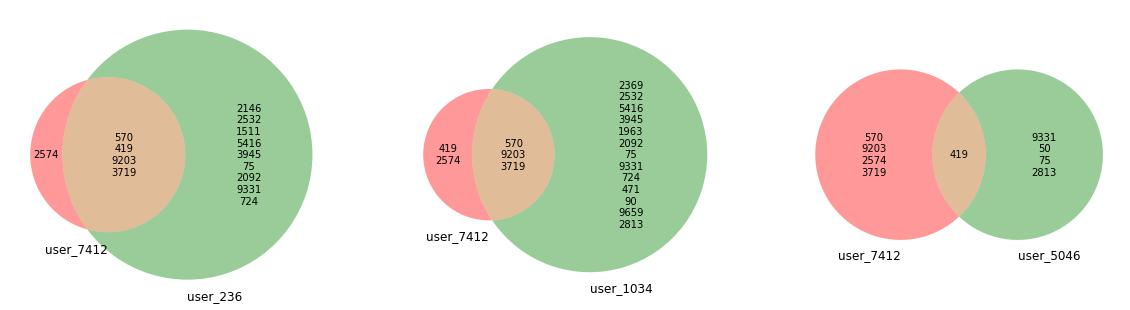

In [83]:
uu=7412




fig,ax=plt.subplots(1,3,figsize=(20,8))
lt_users=[int(re.sub(r'\D','',ii)) for ii in cor_users]

for i,u in enumerate(lt_users):

  set1=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==uu]['new_item_id']))
  set2=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==u]['new_item_id']))

  venn=venn2([set1,set2],['user_'+str(uu),'user_'+str(u)],ax=ax[i])

  venn.get_label_by_id('100').set_text('\n'.join(map(str,set1-set2)))
  venn.get_label_by_id('110').set_text('\n'.join(map(str,set1&set2)))
  venn.get_label_by_id('010').set_text('\n'.join(map(str,set2-set1)))

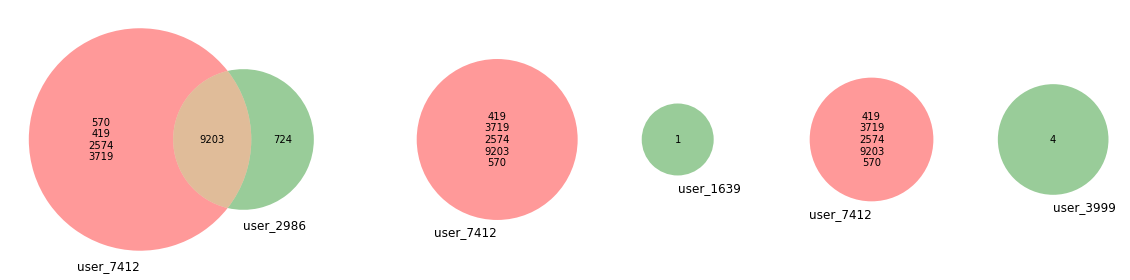

In [84]:
uu=7412




fig,ax=plt.subplots(1,3,figsize=(20,8))
lt_users=[int(re.sub(r'\D','',ii)) for ii in non_cor_users]

for i,u in enumerate(lt_users):

  set1=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==uu]['new_item_id']))
  set2=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==u]['new_item_id']))

  venn=venn2([set1,set2],['user_'+str(uu),'user_'+str(u)],ax=ax[i])
  try:
    venn.get_label_by_id('100').set_text('\n'.join(map(str,set1-set2)))
    venn.get_label_by_id('110').set_text('\n'.join(map(str,set1&set2)))
    venn.get_label_by_id('010').set_text('\n'.join(map(str,set2-set1)))
  except:
    pass
  

# Rough Work

In [ ]:
# set(top_items_id).intersection(set(df_events[df_events.new_vis_id==1176]['new_item_id']))

In [ ]:
items_752=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==752]['new_item_id']))
items_2885=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==2885]['new_item_id']))

items_3466=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==3466]['new_item_id']))
items_5504=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==5504]['new_item_id']))
items_35027=set(top_items_id).intersection(set(df_events[df_events.new_vis_id==35027]['new_item_id']))

In [ ]:
items_752.intersection(items_2885),items_752.intersection(items_2885),items_752.intersection(items_2885)

In [ ]:
items_752.difference(items_2885)

In [ ]:
import re
[int(re.sub(r'\D','',ii)) for ii in cor_users]


In [ ]:
lt_users